## Dataset Selection / Analysis

For our model, we are going to be creating a model that can be feed an image (size 28x28) and determine the character that is found on that image.  

### Sources

There were a few different datasets that were available:

* [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist/)
* [ICDAR 2003 Competition Set](http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2003_Robust_Reading_Competitions#Robust_Reading_and_Text_Locating)

We have decided at this time to use the `ICDAR` dataset. 

In [1]:
# http://www.iapr-tc11.org/dataset/ICDAR2003_RobustReading/TrialTrain/char.zip

### Data Munging

The first thing we are going to do is to update the catalog from xml to json. 

In [3]:
import os
import xml.etree.ElementTree
import json

data_path = '../raw_data'
char_xml = xml.etree.ElementTree.parse(os.path.join(data_path, 'char.xml')).getroot()

output_object = {}
for entry in char_xml:
    tag = entry.get('tag')
    file_name = entry.get('file')
    tag_dict = output_object.get(tag, [])
    tag_dict.append(file_name)
    output_object[tag] = tag_dict

with open(os.path.join(data_path, 'char.json'), 'w', encoding='utf-8') as output_file:
    json.dump(output_object, output_file)

So now we have a new json file that contains the label information and the location of the corresponding images associated with those labels.  

In [2]:
import os
import json
from pprint import pprint

data_path = '../raw_data'

with open(os.path.join(data_path, 'char.json'), 'r', encoding='utf-8') as f:
    catalog = json.load(f)

# Lets see what the data looks like in the catalog. 
pprint({k: (len(v), v[0]) for k, v in catalog.items()})

{'!': (10, 'char/18/1721.jpg'),
 '"': (1, 'char/18/1746.jpg'),
 '&': (7, 'char/20/1920.jpg'),
 "'": (7, 'char/16/1596.jpg'),
 '(': (7, 'char/18/1742.jpg'),
 ')': (7, 'char/18/1747.jpg'),
 '-': (7, 'char/3/294.jpg'),
 '.': (17, 'char/9/850.jpg'),
 '0': (26, 'char/1/36.jpg'),
 '1': (28, 'char/4/349.jpg'),
 '2': (35, 'char/1/34.jpg'),
 '3': (15, 'char/1/26.jpg'),
 '4': (20, 'char/4/338.jpg'),
 '5': (15, 'char/1/35.jpg'),
 '6': (5, 'char/1/27.jpg'),
 '7': (7, 'char/2/127.jpg'),
 '8': (14, 'char/1/28.jpg'),
 '9': (6, 'char/1/29.jpg'),
 ':': (2, 'char/36/3590.jpg'),
 '?': (1, 'char/30/2909.jpg'),
 'A': (221, 'char/1/57.jpg'),
 'B': (52, 'char/1/86.jpg'),
 'C': (146, 'char/1/66.jpg'),
 'D': (108, 'char/2/124.jpg'),
 'E': (326, 'char/1/53.jpg'),
 'F': (59, 'char/1/100.jpg'),
 'G': (76, 'char/1/51.jpg'),
 'H': (81, 'char/2/132.jpg'),
 'I': (183, 'char/1/74.jpg'),
 'J': (15, 'char/3/261.jpg'),
 'K': (28, 'char/1/55.jpg'),
 'L': (164, 'char/1/78.jpg'),
 'M': (80, 'char/1/64.jpg'),
 'N': (168, 'ch

At this point we have our data to work over, we need to understand how we can extract the pixel information from the jpg images (which are using a compressed format).  

Loading: ../raw_data/char/1/57.jpg
Single Pixel: (189, 182, 164)


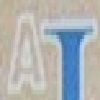

In [3]:
import os

from PIL import Image

data_dir = '../raw_data'

image_to_load = catalog['A'][0]
print('Loading:', os.path.join(data_dir, image_to_load))

image_data = Image.open(os.path.join(data_dir, image_to_load))
print('Single Pixel:', image_data.getdata()[0])
image_data.resize((100, 100))

So the representation of the pixel is currently in RGB form... for our system we want to treat each pixel as a single numeric value, so lets convert the image representation to black and white to see what the differences are. 

Single Pixel: 182


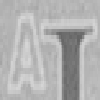

In [4]:
black_white_image = image_data.convert(mode='L')
print('Single Pixel:', black_white_image.getdata()[0])
black_white_image.resize((100, 100))

Ok, so now we have the image with the pixel representation and it is limited to a single numeric value.  This means that we can create a reader that goes through each image... it we quickly look at each file we should be able to verify the sizes that are found...

In [5]:
from collections import Counter

data_dir = '../raw_data'

all_images = Counter([Image.open(os.path.join(data_dir, img)).size 
                for l in catalog.values()
                for img in l])

pprint(len(all_images))

2983


Well that is something that we need to work on... looks like there are a lot of images of different sizes... for our system we want all images to fit into our 28x28 model so we can do a resize as well as a color correction.

In [22]:
from collections import Counter

data_dir = '../raw_data'

formatted_images = [(l, Image.open(os.path.join(data_dir, img)).convert(mode='L').resize((28, 28)))
                      for l, images in catalog.items()
                      for img in images]

Counter([(f.size, len(f.getdata())) for _, f in formatted_images])

Counter({((28, 28), 784): 6185})

Alright, we have a clean common dataset to work with... now we haven't really done anything in the way of real feature engineering and we won't until we have a model to run against it... so with that in mind, lets see what happens when we use a simple sklearn model on our data. 

In [23]:
import numpy as np

np.random.shuffle(formatted_images)

train_size = int(len(formatted_images) * 0.8)
train_data = formatted_images[:train_size]
validate_data = formatted_images[train_size:]
print(len(train_data), len(validate_data))

4948 1237


In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

y = [l.isalpha() for l, _ in train_data]
X = [list(d.getdata()) for _, d in train_data]

model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
from sklearn.metrics import f1_score

X = [list(d.getdata()) for _, d in validate_data]
y_true = [l.isalpha() for l, _ in validate_data]

y_pred = model.predict(X)

f1_score(y_true, y_pred)

0.9586497890295359

So, a simple binary classifier to determine if the image was a character or not seems to have a reasonable f1 score... So now lets try a one hot encoding of the labeled data

In [30]:
y = [l for l, _ in train_data]
X = [list(d.getdata()) for _, d in train_data]

multi_model = LogisticRegression()

multi_model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
from sklearn.metrics import accuracy_score

X = [list(d.getdata()) for _, d in validate_data]
y_true = [l for l, _ in validate_data]

y_pred = multi_model.predict(X)

accuracy_score(y_true, y_pred)

0.07518189167340339

So while the binary classifier to determine if it is an alpha or not... our accuracy score for exact character types was very poor.  